In [6]:
import pandas as pd
import requests
import io

In [7]:
url_endpoint = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'


In [12]:
payload = {
    'Datefrom'   : '01/Jan/2000',
    'Dateto'     : '01/Apr/2024',
    'SeriesCodes': 'IUMBV34,IUMBV37,IUMBV42,IUMBV45',
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
}



headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/54.0.2840.90 '
                  'Safari/537.36'
}

In [13]:
response = requests.get(url_endpoint, params=payload, headers=headers)


# Check if the response was successful, it should return '200'
print(response.status_code)

200


In [14]:
df = pd.read_csv(io.BytesIO(response.content))

In [16]:
df.tail()

,DATE,IUMBV34,IUMBV37,IUMBV42,IUMBV45
286,30 Nov 2023,5.28,5.27,4.89,4.89
287,31 Dec 2023,5.03,5.07,4.68,4.7
288,31 Jan 2024,4.73,4.77,4.44,4.68
289,29 Feb 2024,4.77,4.55,4.40,4.75
290,31 Mar 2024,4.97,4.71,4.53,4.78


In [17]:
# IPython's magic to plot inline
%matplotlib inline

<Axes: >

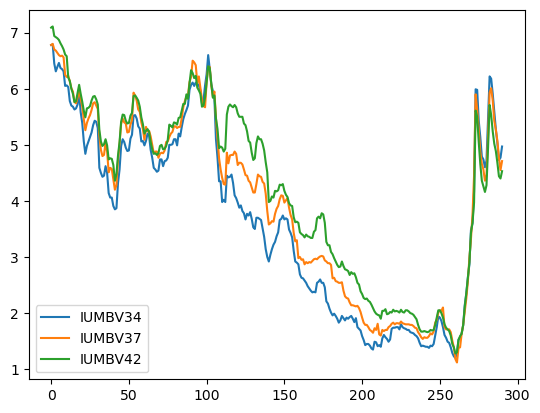

In [18]:
df.plot()


In [1]:
import requests
import pandas as pd
import json
import re
import requests as req
from bs4 import BeautifulSoup as soup
import datetime as dt
from datetime import timedelta
from dateutil.parser import parse

In [8]:
def mse_scrape(url, pages = 1, postdata = "off"):
    
    '''
    ### url: Define url in string format to pull request from
    ### pages: Define number of pages to search for threads on (default is first page only)
    ### postdata: Sequences through all threads in a page and pulls the body of the thread post and date first created. 
    ### Default is turn postdata to off as it can be slow to to run.
    '''
    headers = {
        'Access-Control-Allow-Origin': '*',
        'Access-Control-Allow-Methods': 'GET',
        'Access-Control-Allow-Headers': 'Content-Type',
        'Access-Control-Max-Age': '3600',
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

    
    ### Create dictionary for later creation of pandas DataFrame
    if postdata == "off":
        mse_questions = {"rowhref":[],
                     "rowtitle":[],
                     "viewcount":[],
                     "reply":[]}
        
        page = []
        for p in range(1, pages+1):
            page.append(f"{url}/p{p}")
        
        for link in page:
            urltoscrape = link
    
            reqs = req.get(urltoscrape, headers)
            pool = soup(reqs.content, 'html.parser')
            listofrows = pool.find_all("li", class_="ItemDiscussion")

            for listrows in listofrows:
                ### View Count
                for s in listrows.find_all('span', class_="ViewCount"):
                    for num in s.find_all('span', class_="Number"):
                        viewcount = num.get_text()
                ### Number of comments per post
                for r in listrows.find_all('span', class_="CommentCount"):
                    for comm in r.find_all('span', class_="Number"):
                        reply = comm.get_text()
                ### Get A Tag HREF AND TITLE
                for a in listrows.find_all('a', href=True):
                    if "forums.moneysavingexpert.com" in a['href']:
                        rowhref = a['href']
                        rowtitle = a.get_text()

                    ### Storing data in dictionary
                        mse_questions["rowhref"].append(rowhref)
                        mse_questions["rowtitle"].append(rowtitle)
                        mse_questions["viewcount"].append(viewcount)
                        mse_questions["reply"].append(reply)
    
        df_mse = pd.DataFrame(mse_questions)
        df_mse.to_csv("mse_questions.csv")
        print("CSV file saved in your local directory")
    
    
    ## Create dictionary for later creation of pandas DataFrame - with added body and date of irig
    if postdata == "on":
        mse_questions = {"rowhref":[],
                         "rowtitle":[],
                         "viewcount":[],
                         "reply":[],
                        "body":[],
                        "date_created":[]}
        
        page = []
        for p in range(1, pages+1):
            page.append(f"{url}/p{p}")
            
        for link in page:
            urltoscrape = link

            reqs = req.get(urltoscrape, headers)
            pool = soup(reqs.content, 'html.parser')
            listofrows = pool.find_all("li", class_="ItemDiscussion")

            for listrows in listofrows:
                ### View Count
                for s in listrows.find_all('span', class_="ViewCount"):
                    for num in s.find_all('span', class_="Number"):
                        viewcount = num.get_text()
                ### Number of comments per post
                for r in listrows.find_all('span', class_="CommentCount"):
                    for comm in r.find_all('span', class_="Number"):
                        reply = comm.get_text()
                ### Get A Tag HREF AND TITLE
                for a in listrows.find_all('a', href=True):
                    if "forums.moneysavingexpert.com" in a['href']:
                        rowhref = a['href']
                        rowtitle = a.get_text()

                        url = rowhref
                
                    reqs = req.get(url)
                    nextlevel = soup(reqs.content, 'html.parser')
                    body = nextlevel.find("div", class_="Message userContent")

                if body == None:
                    continue
                else:
                    result_body = body.get_text().strip()


                date_created = nextlevel.find("span", class_="MItem DateCreated").get_text().strip()

                if "Today" in date_created:
                    date_created = date_created.replace("Today", dt.datetime.now().strftime("%d %B"))
                    date_parsed = parse(date_created)

                else:
                    date_parsed = parse(date_created)

              ### Storing data in dictionary for later
                mse_questions["rowhref"].append(rowhref)
                mse_questions["rowtitle"].append(rowtitle)
                mse_questions["viewcount"].append(viewcount)
                mse_questions["reply"].append(reply)
                mse_questions["body"].append(result_body)
                mse_questions["date_created"].append(date_parsed)

        df_mse = pd.DataFrame(mse_questions)
        df_mse.to_csv("mse_data.csv")
        print("CSV file saved in your local directory")
        
    return(df_mse)


In [9]:
mse_savings = "https://www.moneysavingexpert.com/savings/savings-accounts-best-interest/#easyaccess"

In [15]:
mse_page = "https://forums.moneysavingexpert.com/"

In [17]:
mse_scrape(mse_page, 5, "off")

CSV file saved in your local directory


In [18]:
test_df = mse_scrape("https://forums.moneysavingexpert.com/categories/small-biz-charities-moneysaving", 5, "off")

CSV file saved in your local directory
